In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from scipy.stats import lognorm

In [3]:
%run parcel.ipynb

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [5]:
#size = 100
#epsilon = 5

#a = np.array([10]).reshape(-1,1)
#b = np.full((1,50), size - epsilon)
#c = np.full((1,50), size + epsilon)
#d = np.full((1, np.size(b) + np.size(c)), size)

# Realizacja 1) - 50 kropel większych, 50 mniejszych
#rd[0] = np.concatenate((a,b,c),axis = 1).reshape(101,) * si.nanometre

# Realizacja 2) - 100 kropel w średnim rozmiarze
#rd[1] = np.concatenate((a,d),axis = 1).reshape(101,) * si.nanometre

In [6]:
rd = [np.empty(2), np.empty(3)]
nd = [np.empty(2), np.empty(3)]

rd[0] = np.array([  5, 200]) * si.nanometre
nd[0] = np.array([500, 100]) / si.milligram

rd[1] = np.array([  5, 150, 250]) * si.nanometre
nd[1] = np.array([500, 50,  50]) / si.milligram

In [7]:
no = 2
nones = lambda: [None] * no

In [8]:
assert len(rd) == no
assert len(nd) == no
integ, sys = nones(), nones()
for i in range(no):
    integ[i], sys[i] = parcel(
        si = si,
        t = 40 * si.seconds,
        T0 = 300 * si.kelvin,
        q0 = 21 * si.grams / si.kilogram,
        p0 = 1000 * si.hectopascals,
        w = lambda t: 10* si.metre / si.second,
        nd = nd[i], 
        rd = rd[i], 
        kp = 1.28,
        dt_max = 0.1 * si.second
    )

C:\Users\Michael\Anaconda3\lib\site-packages\pint\quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [9]:
ixs = nones()
ixs[0] = sys[0].ix
ixs[1] = sys[1].ix

fn = sys[0].fn
ph = sys[0].ph

In [10]:
T, p, q, r, t, dr_dt= nones(), nones(), nones(), nones(), nones(), nones()
for i in range(no):
    T[i] = integ[i].y[ixs[i].T] * ixs[i].T_unit
    p[i] = integ[i].y[ixs[i].p] * ixs[i].p_unit
    q[i] = integ[i].y[ixs[i].q] * ixs[i].q_unit
    r[i] = fn.r(integ[i].y[ixs[i].x] * ixs[i].x_unit)
    t[i] = integ[i].t * ixs[i].t_unit

    dr_dt[i] = np.empty_like(r[i]) * ixs[i].r_unit / ixs[i].t_unit
    for j, tau in enumerate(integ[i].t):
        y = integ[i].y[:, j]
        dx_dt = sys[i](tau, y)[ixs[i].x] * ixs[i].x_unit / ixs[i].t_unit
        x = y[ixs[i].x] * ixs[i].x_unit
        dr_dt[i].magnitude[:, j] = dx_dt / fn.dx_dr(fn.r(x))

In [11]:
lw = lambda i: 1.5 * (2-i)

In [12]:
print((r[0][0][0]).to(si.nanometre))

print((r[0][1][0]).to(si.nanometre))

print((r[1][0][0]).to(si.nanometre))

print((r[1][1][0]).to(si.nanometre))

print((r[1][2][0]).to(si.nanometre))

13.287262752515357 nanometer
564.9674219757054 nanometer
13.287262752515357 nanometer
422.1884802802472 nanometer
707.755629734441 nanometer


<IPython.core.display.Javascript object>


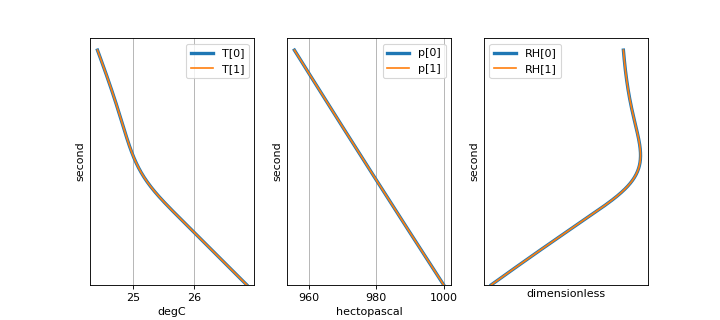

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

for i in range(no):
    ax1.plot(T[0], t[0], label="T["+str(i)+"]", lw=lw(i))
    ax2.plot(p[0], t[0], label="p["+str(i)+"]", lw=lw(i))
    ax3.plot(ph.RH(T[i], p[i], q[i]), t[i], label="RH["+str(i)+"]", lw=lw(i))

ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.grid()
ax3.legend()



### Nazwa notebooka lekko oszukana, bo  $A,B \neq 0 $

In [14]:
r_cr = (ph.r_cr(sys[0].kp, rd[0][0], T[0][:]).to(si.nanometre))


<IPython.core.display.Javascript object>


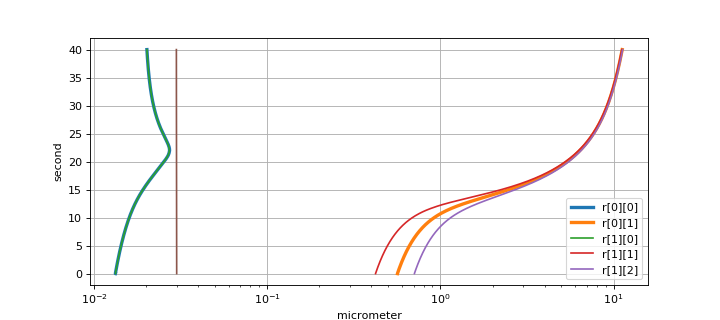

In [15]:
fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
for i in range(no):
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        plt.plot(r[i][j], t[i], label="r[" + str(i)+ "]["+str(j)+"]", lw=lw(i))

plt.plot(r_cr,t[0])

plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.legend()
ax1.xaxis.set_units(si.micrometre)
plt.show()

plt.savefig('pics/radii_with_vs_without_ripening.pdf')

<IPython.core.display.Javascript object>


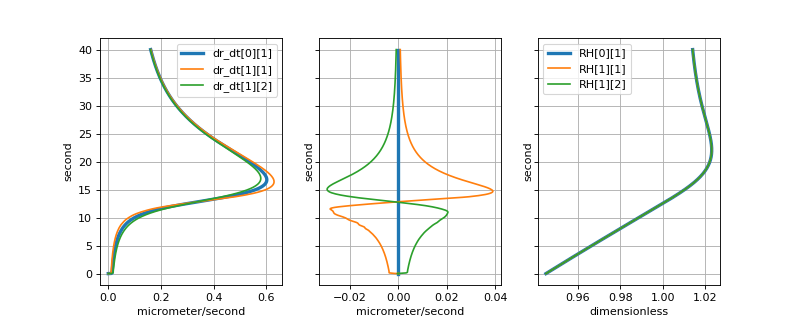

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharey=True)
for i in range(no):
    for j in range( 1,ixs[i].x.stop - ixs[i].x.start):
        y = t[0]
        x = np.empty_like(dr_dt[0][1]) * dr_dt[0].units
        x.magnitude[:] = np.interp(y, t[i], dr_dt[i][j]) 
        ax1.plot(x, y, label="dr_dt[" + str(i)+ "]["+str(j)+"]", lw = lw(i))
        ax2.plot(x - dr_dt[0][1], y, label="dr_dt[" + str(i)+ "]["+str(j)+"] - dr_dt[0][1]", lw = lw(i))
        ax3.plot(ph.RH(T[i], p[i], q[i]), t[i], label="RH[" + str(i)+ "]["+str(j)+"]", lw=lw(i))
#         ax4.plot(ph.A(T[i]/r[i]),t[i])


#plt.xscale('log')
#plt.xlim(1e-2, .7)
# plt.yscale('log')
ax1.grid()
ax1.xaxis.set_units(si.micrometre/si.second)
ax1.legend()

ax2.grid()
ax2.xaxis.set_units(si.micrometre/si.second)
# ax2.legend(loc="upper right")

ax3.grid()
ax3.legend()

plt.show()


plt.savefig('pics/comparision_with_without_broadening.pdf')